In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

In [2]:
from IPython.display import Markdown, display

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
from aif360.datasets import AdultDataset, BankDataset, CompasDataset, GermanDataset, LawSchoolGPADataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

In [5]:
from BiasGenerator.TemporalBiasGenerator import TemporalBiasGenerator
from BiasGenerator.CauseEffectBiasGenerator import CauseEffectBiasGenerator
from BiasGenerator.SamplingBiasGenerator import SamplingBiasGenerator
from BiasGenerator.MeasurementBiasGenerator import MeasurementBiasGenerator
from BiasGenerator.OmittedVariableBiasGenerator import OmittedVariableBiasGenerator
from BiasGenerator.SimpsonsParadoxGenerator import SimpsonsParadoxGenerator

In [6]:
from Data import Data

# Generic title

In [7]:
def plot(d):
    print(d)
    plt.ylabel("Accuracy")
    plt.xlabel("Bias")
    for i in d:
        plt.plot(d[i]["bias"], d[i]["accuracy"], marker="o", markersize="10")
        plt.annotate(i, (d[i]["bias"], d[i]["accuracy"]), textcoords="offset points", xytext=(0,10), ha='center') 
    plt.show()

In [8]:
def fromAif(data):
    extracted_df = data.convert_to_dataframe()
    df = extracted_df[0]
    pa = extracted_df[1]["protected_attribute_names"]
    l  = extracted_df[1]["label_names"]
    w  = extracted_df[1]["instance_weights"]
    return Data(df=df, protected_attributes=pa, labels=l, weights=w)

In [9]:
RANDOM_STATE = 42
TRAIN_TEST_RATIO = 0.2

np.random.seed(RANDOM_STATE)

# Grades dataset

### Loading data

In [10]:
def load_grades():
    return pd.read_csv("data/famous/CompleteDataAndBiases.csv", index_col="index")

### Preprocessing data

In [11]:
def preproc_grades():
    data = load_grades()

    # remove unwanted features
    data = data.drop(["ParticipantID", "name", "G3", "PredictedRank", "PredictedGrade", "StereotypeActivation"], axis=1)
    # binarize sex
    data["sex"] = data["sex"].apply(lambda x: 1 if x == "F" else 0)
    data["Pass"] = data["Pass"].apply(lambda x: 1 if x else 0)

    # one hot encoding
    one_hot = pd.get_dummies(data[["romantic", "reason"]])
    data = data.drop(["romantic", "reason"], axis=1)
    data = data.join(one_hot)

    fair_data = data.copy()
    fair_data = fair_data.drop(["Predicted_Pass_RankingStrategy", "Predicted_Pass_PassFailStrategy"], axis=1)

    biased_data = data.drop(["Pass",  "Predicted_Pass_PassFailStrategy"], axis=1)
    biased_data = biased_data.rename(columns={"Predicted_Pass_RankingStrategy": "Pass"})
    biased_data["Pass"] = biased_data["Pass"].apply(lambda x: 1 if x else 0)

    return fair_data, biased_data

In [12]:
def split_grades():
    fair, biased = preproc_grades()
    biased_train, biased_test, fair_train, fair_test = train_test_split(biased, fair, test_size=TRAIN_TEST_RATIO, random_state=RANDOM_STATE)
    
    biased_data_train = Data(biased_train, ["sex"], ["Pass"])
    biased_data_test = Data(biased_test, ["sex"], ["Pass"])

    fair_data_train = Data(fair_train, ["sex"], ["Pass"])
    fair_data_test = Data(fair_test, ["sex"], ["Pass"])
    
    return biased_data_train, biased_data_test, fair_data_train, fair_data_test

### Rebiasing using our method


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Testing unfair baseline...
Testing fair baseline...
Testing measurement...
Testing measurement Y...
Testing measurement A...
Testing Omitted (bias)...
Testing Omitted (fair)...
Testing Sampling (men)...
{'Pass': {0: 0.5, 1: 1}} {'Pass': 1.5}
0.15
0.3
Testing Sampling (women)...
{'Pass': {0: 0.5, 1: 1}} {'Pass': 1.5}
0.15
0.3
Testing Sampling (forced)...
{'Pass': {0: 0, 1: 1}} {'Pass': 1}
0.0
0.6666666666666666
{'Pass': {0: 0, 1: 1}} {'Pass': 1}
0.0
0.25
{'unfair baseline': {'accuracy': 0.75, 'bias': -0.2116325204364332}, 'fair baseline': {'accuracy': 0.8372093023255814, 'bias': -0.04268563806136061}, 'measurement': {'accuracy': 0.8313953488372093, 'bias': -0.04268563806136061}, 'measurement Y': {'accuracy': 0.813953488372093, 'bias': -0.228973560898861}, 'measurement A': {'accuracy': 0.8372093023255814, 'bias': -0.052131156208418905}, 'Omitted (bias)': {'accuracy': 0.8313953488372093, 'bias': -0.2116325204364332}, 'Omitted (fair)': {'accuracy': 0.8313953488372093, 'bias': -0.0426856380

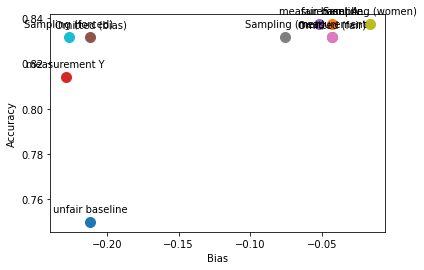

In [13]:
class GradesDatasetTester:
    def __init__(self):
        btr, bte, ftr, fte = split_grades()
        self.biased_train = btr
        self.biased_test = bte
        self.fair_train = ftr
        self.fair_test = fte
    
    def test_all(self, params):
        results = dict()
        results.update(self.basic_unfair())
        results.update(self.basic_fair())
        results.update(self.basic_measurement(params["measurement"], params["a"]))
        results.update(self.y_measurement(params["y"], params["a"]))
        results.update(self.a_measurement(params["a"]))
        results.update(self.omit_bias(params["omit"]))
        results.update(self.omit_fair(params["omit"]))
        results.update(self.sampling_men(params["y"], params["a"]))
        results.update(self.sampling_women(params["y"], params["a"]))
        results.update(self.sampling_forced(params["y"], params["a"]))
        return results
        
    def test_data(self, data, omit=None):
        X_train = data.X()
        y_train = data.y()
        X_test = self.biased_test.X().copy()
        
        if omit is not None:
            X_test = Data(X_test, [], [])
            for i in omit:
                X_test = OmittedVariableBiasGenerator(parameter_to_omit=i).apply(X_test)
                
            X_test = X_test.df(False)
        model = LogisticRegression(max_iter=200)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)
        return {"preds": preds, "proba": proba}
    
    def evaluate_results(self, results, data):
        preds = results["preds"]
        proba = results["proba"]
        ground_truth = self.fair_test.y()
        
        accuracy = accuracy_score(ground_truth, preds)
        bias = data.metrics().mean_difference()
        
        return {"accuracy": accuracy, "bias": bias}
    
    def basic_unfair(self):
        name = "unfair baseline"
        print(f"Testing {name}...")
        
        train = self.biased_train
        return {name: self.evaluate_results(self.test_data(train), train)}
        
    def basic_fair(self):
        name = "fair baseline"
        print(f"Testing {name}...")
        
        train = self.fair_train
        return {name: self.evaluate_results(self.test_data(train), train)}
     
    def basic_measurement(self, measurement, A):
        name = "measurement"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        for l in measurement:
            train = MeasurementBiasGenerator(parameter=A, parameter_value=1, measurement=l, bias_strength=1).apply(train)
            
        return {name: self.evaluate_results(self.test_data(train), train)}
    
    def y_measurement(self, y, A):
        name = "measurement Y"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        # add new direct bias for females
        train = MeasurementBiasGenerator(parameter=A, parameter_value=1, 
                                         measurement=y, bias_strength=0.08,
                                         weight = {"invalid_ratio": 0,
                                                   "measurement_error": [1, 0]}).apply(train)
        # add new direct bias for males
        train = MeasurementBiasGenerator(parameter=A, parameter_value=0, 
                                         measurement=y, bias_strength=0.315,
                                         weight = {"invalid_ratio": 0,
                                                   "measurement_error": [1, 0]}).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train), train)}
    
    def a_measurement(self, A):
        name = "measurement A"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        train = MeasurementBiasGenerator(parameter=A, parameter_value=1, 
                                         measurement=A, bias_strength=0.3,
                                         weight = {"invalid_ratio": 0,
                                                   "measurement_error": [0.5, 0.5]}).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train), train)}
    
    def omit_bias(self, omit):
        name = "Omitted (bias)"
        print(f"Testing {name}...")
        train = self.biased_train.copy() 
        
        for i in omit:
            train = OmittedVariableBiasGenerator(parameter_to_omit=i).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train, omit=omit), train)}
     
    def omit_fair(self, omit):
        name = "Omitted (fair)"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        for i in omit:
            train = OmittedVariableBiasGenerator(parameter_to_omit=i).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train, omit=omit), train)}
    
    def sampling_men(self, Y, A):
        name = "Sampling (men)"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        train = SamplingBiasGenerator(parameter=A, parameter_value=0, weight={Y: {0:0.5, 1:1}}, bias_strength=0.3).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train), train)}
    
    def sampling_women(self, Y, A):
        name = "Sampling (women)"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        train = SamplingBiasGenerator(parameter=A, parameter_value=1, weight={Y: {0:0.5, 1:1}}, bias_strength=0.3).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train), train)}
    
    def sampling_forced(self, Y, A):
        name = "Sampling (forced)"
        print(f"Testing {name}...")
        train = self.fair_train.copy() 
        
        train = SamplingBiasGenerator(parameter=A, parameter_value=0, weight={Y: {0:0, 1:1}}, bias_strength=2/3).apply(train)
        train = SamplingBiasGenerator(parameter=A, parameter_value=1, weight={Y: {0:0, 1:1}}, bias_strength=1/4).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train), train)}
        
grades = GradesDatasetTester()
params = {"measurement": ["studytime", "freetime", "Walc", "goout", "Parents_edu", "absences"],
         "a": "sex",
         "y": "Pass",
         "omit": ["studytime", "freetime", "Parents_edu", "absences", "Walc", "goout", "romantic_no", "romantic_yes", "reason_course", "reason_home", "reason_reputation", "reason_other"]}

plot(grades.test_all(params))

# Synthetic dataset

In [14]:
def synth(num):
    with open(f"data/synthetic/{num}_x.p", "rb") as f:
        data = pickle.load(f)
    
    train, test = data.split(0.2)
    
    grades = GradesDatasetTester()
    grades.biased_train = train
    grades.fair_train = train
    grades.biased_test = test
    grades.fair_test = test
    
    params = {"measurement": [f"X{i}" for i in range(num)],
         "a": "A",
         "y": "Y",
         "omit": [[f"X{i}" for i in range(num)]]}
    
    plot(grades.test_all(params))

### size = 5


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Testing unfair baseline...
Testing fair baseline...
Testing measurement...
Testing measurement Y...
Testing measurement A...
Testing Omitted (bias)...
Testing Omitted (fair)...
Testing Sampling (men)...
{'Y': {0: 0.5, 1: 1}} {'Y': 1.5}
0.15
0.3
Testing Sampling (women)...
{'Y': {0: 0.5, 1: 1}} {'Y': 1.5}
0.15
0.3
Testing Sampling (forced)...
{'Y': {0: 0, 1: 1}} {'Y': 1}
0.0
0.6666666666666666
{'Y': {0: 0, 1: 1}} {'Y': 1}
0.0
0.25
{'unfair baseline': {'accuracy': 0.6996, 'bias': 0.006165610026242552}, 'fair baseline': {'accuracy': 0.6996, 'bias': 0.006165610026242552}, 'measurement': {'accuracy': 0.69235, 'bias': 0.006165610026242552}, 'measurement Y': {'accuracy': 0.66355, 'bias': -0.08870770061975086}, 'measurement A': {'accuracy': 0.6996, 'bias': 0.002066141357645379}, 'Omitted (bias)': {'accuracy': 0.6007, 'bias': 0.006165610026242552}, 'Omitted (fair)': {'accuracy': 0.6007, 'bias': 0.006165610026242552}, 'Sampling (men)': {'accuracy': 0.6992, 'bias': -0.0395004349576471}, 'Sampling

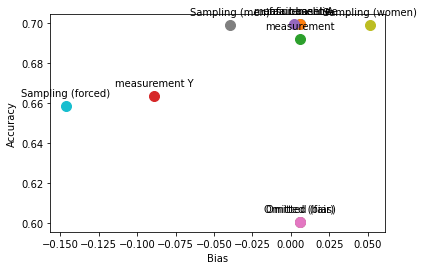

In [15]:
synth(5)

### size = 10


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Testing unfair baseline...
Testing fair baseline...
Testing measurement...
Testing measurement Y...
Testing measurement A...
Testing Omitted (bias)...
Testing Omitted (fair)...
Testing Sampling (men)...
{'Y': {0: 0.5, 1: 1}} {'Y': 1.5}
0.15
0.3
Testing Sampling (women)...
{'Y': {0: 0.5, 1: 1}} {'Y': 1.5}
0.15
0.3
Testing Sampling (forced)...
{'Y': {0: 0, 1: 1}} {'Y': 1}
0.0
0.6666666666666666
{'Y': {0: 0, 1: 1}} {'Y': 1}
0.0
0.25
{'unfair baseline': {'accuracy': 0.7497, 'bias': -0.00018697863822980665}, 'fair baseline': {'accuracy': 0.7497, 'bias': -0.00018697863822980665}, 'measurement': {'accuracy': 0.72835, 'bias': -0.00018697863822980665}, 'measurement Y': {'accuracy': 0.72125, 'bias': -0.09401271854874088}, 'measurement A': {'accuracy': 0.74925, 'bias': -8.346499318950817e-05}, 'Omitted (bias)': {'accuracy': 0.5966, 'bias': -0.00018697863822980665}, 'Omitted (fair)': {'accuracy': 0.5966, 'bias': -0.00018697863822980665}, 'Sampling (men)': {'accuracy': 0.7468, 'bias': -0.0458305381

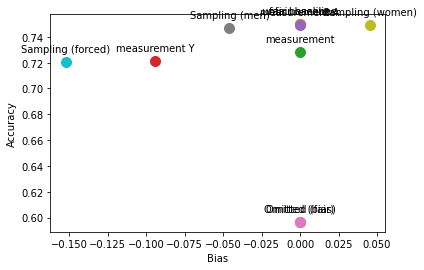

In [16]:
synth(10)

### size = 20


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Testing unfair baseline...
Testing fair baseline...
Testing measurement...
Testing measurement Y...
Testing measurement A...
Testing Omitted (bias)...
Testing Omitted (fair)...
Testing Sampling (men)...
{'Y': {0: 0.5, 1: 1}} {'Y': 1.5}
0.15
0.3
Testing Sampling (women)...
{'Y': {0: 0.5, 1: 1}} {'Y': 1.5}
0.15
0.3
Testing Sampling (forced)...
{'Y': {0: 0, 1: 1}} {'Y': 1}
0.0
0.6666666666666666
{'Y': {0: 0, 1: 1}} {'Y': 1}
0.0
0.25
{'unfair baseline': {'accuracy': 0.8006, 'bias': -0.002545268347381613}, 'fair baseline': {'accuracy': 0.8006, 'bias': -0.002545268347381613}, 'measurement': {'accuracy': 0.79655, 'bias': -0.002545268347381613}, 'measurement Y': {'accuracy': 0.7755, 'bias': -0.09510658729294946}, 'measurement A': {'accuracy': 0.8009, 'bias': -0.004805895701266938}, 'Omitted (bias)': {'accuracy': 0.5989, 'bias': -0.002545268347381613}, 'Omitted (fair)': {'accuracy': 0.5989, 'bias': -0.002545268347381613}, 'Sampling (men)': {'accuracy': 0.80085, 'bias': -0.04806020532364347}, 'S

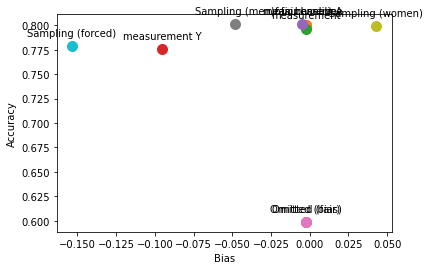

In [17]:
synth(20)

### size = 50

Testing unfair baseline...



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Testing fair baseline...
Testing measurement...
Testing measurement Y...
Testing measurement A...
Testing Omitted (bias)...
Testing Omitted (fair)...
Testing Sampling (men)...
{'Y': {0: 0.5, 1: 1}} {'Y': 1.5}
0.15
0.3
Testing Sampling (women)...
{'Y': {0: 0.5, 1: 1}} {'Y': 1.5}
0.15
0.3
Testing Sampling (forced)...
{'Y': {0: 0, 1: 1}} {'Y': 1}
0.0
0.6666666666666666
{'Y': {0: 0, 1: 1}} {'Y': 1}
0.0
0.25
{'unfair baseline': {'accuracy': 0.9159, 'bias': -0.0006910528022482376}, 'fair baseline': {'accuracy': 0.9159, 'bias': -0.0006910528022482376}, 'measurement': {'accuracy': 0.8964, 'bias': -0.0006910528022482376}, 'measurement Y': {'accuracy': 0.8745, 'bias': -0.09166346317219864}, 'measurement A': {'accuracy': 0.91495, 'bias': -5.328235722779073e-05}, 'Omitted (bias)': {'accuracy': 0.5966, 'bias': -0.0006910528022482376}, 'Omitted (fair)': {'accuracy': 0.5966, 'bias': -0.0006910528022482376}, 'Sampling (men)': {'accuracy': 0.9162, 'bias': -0.046194006045556346}, 'Sampling (women)': {'a

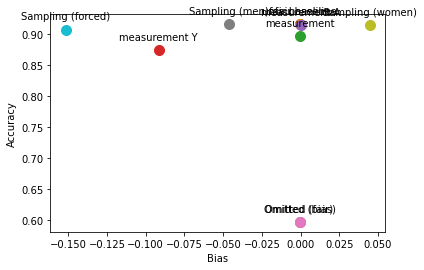

In [18]:
synth(50)

# German Dataset
w.r.t. age

In [19]:
def german_age_reweighing():
    # get dataset
    dataset_orig = GermanDataset(
        protected_attribute_names=['age'],           # this dataset also contains protected
                                                     # attribute for "sex" which we do not
                                                     # consider in this evaluation
        privileged_classes=[lambda x: x >= 25],      # age >=25 is considered privileged
        features_to_drop=['personal_status', 'sex']  # ignore sex-related attributes
    )
    
    # split dataset
    dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True, seed=RANDOM_STATE)

    privileged_groups = [{'age': 1}]
    unprivileged_groups = [{'age': 0}]

    # Original fairness
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    display(Markdown("#### Original training dataset"))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # Debias with reweighing
    RW = Reweighing(unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)
    dataset_transf_train = RW.fit_transform(dataset_orig_train)

    # new fairness
    metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                                   unprivileged_groups=unprivileged_groups,
                                                   privileged_groups=privileged_groups)
    display(Markdown("#### Transformed training dataset"))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

    # return debiased dataset
    ftr = fromAif(dataset_transf_train)
    fte = fromAif(RW.transform(dataset_orig_test))
    btr = fromAif(dataset_orig_train)
    bte = fromAif(dataset_orig_test)

    print("fair:")
    print(ftr.df(weight=True).groupby(["age", "credit"])["__weight__"].mean())
    print("bias:")
    print(btr.df(weight=True).groupby(["age", "credit"]).size())
    
    # cast 1, 2 --> 1, 0
    for t in [ftr, fte, btr, bte]:
        t._df["credit"] = t._df["credit"].apply(lambda x: 1 if x == 1 else 0)
    return ftr, fte, btr, bte

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.127143


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000
fair:
age  credit
0.0  1.0       1.183143
     2.0       0.731986
1.0  1.0       0.974563
     2.0       1.065800
Name: __weight__, dtype: float64
bias:
age  credit
0.0  1.0        60
     2.0        41
1.0  1.0       432
     2.0       167
dtype: int64
Testing fair baseline...
Testing unfair baseline...
Testing sampling...
{'credit': {0: 0.974563, 1: 1.183143}} {'credit': 2.157706}
0.8237068553843448
1.0
{'credit': {0: 1.0658, 1: 0.731986}} {'credit': 1.797786}
1.0
0.6867948958528804
Testing measurement...
{'fair baseline': {'accuracy': 0.76, 'bias': 2.220446049250313e-16}, 'unfair baseline': {'accuracy': 0.76, 'bias': -0.12714259739830414}, 'sampling': {'accuracy': 0.69, 'bias': -1.0}, 'measurement': {'accuracy': 0.7566666666666667, 'bias': -0.16131010452961658}}


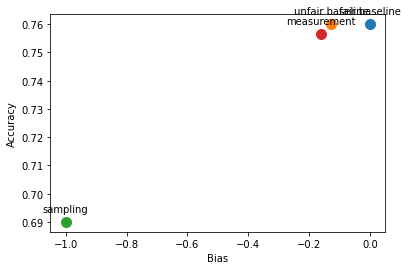

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.127143


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000
fair:
age  credit
0.0  1.0       1.183143
     2.0       0.731986
1.0  1.0       0.974563
     2.0       1.065800
Name: __weight__, dtype: float64
bias:
age  credit
0.0  1.0        60
     2.0        41
1.0  1.0       432
     2.0       167
dtype: int64
Testing fair baseline...
Testing unfair baseline...
Testing sampling...
{'credit': {0: 0.974563, 1: 1.183143}} {'credit': 2.157706}
0.8237068553843448
1.0
{'credit': {0: 1.0658, 1: 0.731986}} {'credit': 1.797786}
1.0
0.6867948958528804
Testing measurement...
{'fair baseline': {'accuracy': 0.76, 'bias': 2.220446049250313e-16}, 'unfair baseline': {'accuracy': 0.76, 'bias': -0.12714259739830414}, 'sampling': {'accuracy': 0.69, 'bias': -1.0}, 'measurement': {'accuracy': 0.74, 'bias': -0.06759581881533094}}


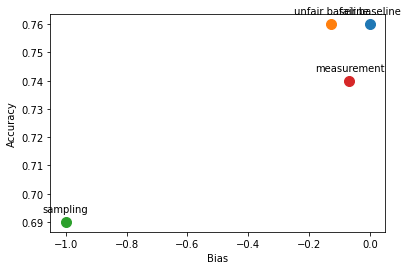

In [20]:
class GermanTester:
    def __init__(self, fair):
        ftr, fte, btr, bte = german_age_reweighing()
        self.train = ftr
        self.test = fte
        self.bias_train = btr
        self.bias_test = bte
        self.fair = fair
        
    def test_all(self, params):
        results = dict()
        results.update(self.baseline())
        results.update(self.unfair_baseline())
        results.update(self.sampling(params["y"], params["a"]))
        results.update(self.measurement(params["y"], params["a"]))
        return results
        
    def test_data(self, data, omit=None):
        X_train = data.X()
        y_train = data.y()
        
        if self.fair:
            X_test = self.test.X().copy()
        else:
            X_test = self.bias_test.X().copy()
        
        if omit is not None:
            X_test = Data(X_test, [], [])
            for i in omit:
                X_test = OmittedVariableBiasGenerator(parameter_to_omit=i).apply(X_test)
                
            X_test = X_test.df(False)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_test)
        proba = model.predict_proba(X_test)
        return {"preds": preds, "proba": proba}
    
    def evaluate_results(self, results, data):
        preds = results["preds"]
        proba = results["proba"]
        
        if self.fair:
            ground_truth = self.test.y()
        else:
            ground_truth = self.bias_test.y()
        
        accuracy = accuracy_score(ground_truth, preds)
        bias = data.metrics().mean_difference()
        
        return {"accuracy": accuracy, "bias": bias}
    
    def baseline(self):
        name = "fair baseline"
        print(f"Testing {name}...")
        
        train = self.train
        return {name: self.evaluate_results(self.test_data(train), train)}
    
    def unfair_baseline(self):
        name = "unfair baseline"
        print(f"Testing {name}...")
        
        train = self.bias_train
        return {name: self.evaluate_results(self.test_data(train), train)}
    
    def sampling(self, y, A):
        name = "sampling"
        print(f"Testing {name}...")
        train = self.train.copy() 
        
        train = SamplingBiasGenerator(parameter=A, parameter_value=0, weight={y: {0:0.974563, 1:1.183143}}, bias_strength=1, seed=RANDOM_STATE).apply(train)
        train = SamplingBiasGenerator(parameter=A, parameter_value=1, weight={y: {0:1.065800, 1:0.731986}}, bias_strength=1, seed=RANDOM_STATE).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train), train)}

    def measurement(self, y, A):
        name = "measurement"
        print(f"Testing {name}...")
        train = self.train.copy() 
        
        
        train = MeasurementBiasGenerator(parameter=A, parameter_value=0, 
                                         measurement=y, bias_strength=0.731986/1.183143,
                                         weight = {"invalid_ratio": 0,
                                                   "measurement_error": [0, 1]}).apply(train)
        
        train = MeasurementBiasGenerator(parameter=A, parameter_value=0, 
                                         measurement=y, bias_strength=0.974563/1.065800,
                                         weight = {"invalid_ratio": 1,
                                                   "measurement_error": [1, 0]}).apply(train)
        
        return {name: self.evaluate_results(self.test_data(train), train)}

    
    
german = GermanTester(fair=True)
params = {"y": "credit", "a": "age"}
plot(german.test_all(params))

german = GermanTester(fair=False)
params = {"y": "credit", "a": "age"}
plot(german.test_all(params))